In [1]:
from operator import itemgetter
import pandas as pd
import numpy as np
# from numpy.polynomial.polynomial import polyfit
import statsmodels as stt
import scipy.stats as sst
import scipy.linalg as lin
import os.path as osp
from statsmodels import api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import json
from time import gmtime, strftime
# %matplotlib inline

In [2]:
print(osp.realpath(osp.curdir))

csv_filename = '2019-12-21-simple2_query_output2.csv'
csv_filename = '2020-02-11-simple2_query_output.csv'
csv_filename = '2020-03-26_simple2_query_output.csv'
relative_dir = './data'
figure_dir = './figures'

# relative_path_filename = './data/2019-12-03-simple2_query_output.csv' 
#relative_path_filename = './data/2019-12-21-simple2_query_output2.csv'
relative_path_filename = osp.join(relative_dir, csv_filename)
assert osp.exists(relative_path_filename)
print(relative_path_filename)

/home/jb/code/repronim/simple2/simple2_analysis
./data/2020-03-26_simple2_query_output.csv


In [3]:

hie = pd.read_csv(relative_path_filename, na_values='nd') #, low_memory=False)
original_col_names = list(hie)
# column names are unique
assert len(original_col_names) == len(set(original_col_names))
print(list(hie))
col_rename = {'federatedLabel':'structure'}
hie.rename(columns=col_rename, inplace=True)
print(list(hie))

['study', 'ID', 'Age', 'dx', 'Gender', 'FIQ', 'PIQ', 'VIQ', 'tool', 'softwareLabel', 'federatedLabel', 'laterality', 'volume']
['study', 'ID', 'Age', 'dx', 'Gender', 'FIQ', 'PIQ', 'VIQ', 'tool', 'softwareLabel', 'structure', 'laterality', 'volume']


/home/jb/virtualenvs/simple2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
set(hie['structure'])
[roi for roi in set(hie['softwareLabel']) if ('CC_' in roi and 'Volume_mm3' in roi)]

['CC_Central Volume_mm3 (mm^3)',
 'CC_Mid_Anterior Volume_mm3 (mm^3)',
 'CC_Posterior Volume_mm3 (mm^3)',
 'CC_Mid_Posterior Volume_mm3 (mm^3)',
 'CC_Anterior Volume_mm3 (mm^3)']

In [5]:
# Read the mapping file, that contains Freesurfer data elements with link to uberon isAbout

# mapping_file = '../segstats_jsonld/segstats_jsonld/mapping_data/freesurfermap.json'
mapping_file = '../segstats_jsonld/segstats_jsonld/mapping_data/freesurfer-cdes.json'
assert osp.exists(mapping_file)
with open(mapping_file, "r") as read_file:
    roi_map = json.load(read_file)

In [6]:
# this takes the mapping and spits out a dict with key is uberon 
# and value is roi definition
# eg: {'http://purl.obolibrary.org/obo/UBERON_0001874': 'Putamen'}
# will be use to get roi (eg Putamen) across software

ube2h = {}
label2ube = {}
countok=0
has_no_isAbout = []
has_no_label = []

for (k,v) in roi_map.items():
    
    # the mapping file starts with "count" at the level of data elements - need to discard 'count'
    if k == 'count': pass
    
    # v is a dict that contains the CDE - check that we have a isAbout and label    
    elif 'isAbout' in v:
        countok += 1
        if 'label' in v:
            if v['label'] != '' and v['label'] not in ('None','none'):
                #ube['<' + v['isAbout'] + '>'] = v['label']
                #ebu[v['label']] = '<' + v['isAbout'] + '>'
                label2ube[v['label']] = v['isAbout']
                if v['isAbout'] not in ube2h.keys():
                    no_right_or_left = v['label']
                    no_right_or_left = no_right_or_left.replace('Right-','')
                    no_right_or_left = no_right_or_left.replace('Right ','')
                    no_right_or_left = no_right_or_left.replace('Left-','')
                    no_right_or_left = no_right_or_left.replace('Left ','')
                    no_right_or_left = no_right_or_left.replace(' NVoxels','')
                    no_right_or_left = no_right_or_left.replace(' (mm^3)','')
                    ube2h[v['isAbout']] = no_right_or_left
            else:
                has_no_label.append(k)

assert has_no_isAbout == []
assert countok == len(label2ube)

In [7]:
label2ube;
ube2h
h2ube = {v: k for k, v in ube2h.items()}

In [8]:
print(ube2h)

{'http://purl.obolibrary.org/obo/UBERON_0000956': 'Number of Vertices', 'http://purl.obolibrary.org/obo/UBERON_0000955': 'Brain Segmentation Volume', 'http://purl.obolibrary.org/obo/UBERON_0001869': 'Supratentorial volume', 'http://purl.obolibrary.org/obo/UBERON_0013411': 'Estimated Total Intracranial Volume', 'http://purl.obolibrary.org/obo/UBERON_0002437': 'hemisphere cerebral white matter volume', 'http://purl.obolibrary.org/obo/UBERON_0005401': 'Total gray matter volume', 'http://purl.obolibrary.org/obo/UBERON_0002285': 'Lateral-Ventricle', 'http://purl.obolibrary.org/obo/UBERON_0006091': 'Inf-Lat-Vent', 'http://purl.obolibrary.org/obo/UBERON_0002317': 'Cerebellum-White-Matter', 'http://purl.obolibrary.org/obo/UBERON_0002129': 'Cerebellum-Cortex', 'http://purl.obolibrary.org/obo/UBERON_0001897': 'Thalamus-Proper', 'http://purl.obolibrary.org/obo/UBERON_0001873': 'Caudate', 'http://purl.obolibrary.org/obo/UBERON_0001874': 'Putamen', 'http://purl.obolibrary.org/obo/UBERON_0006514': '

In [9]:
def split_op_merge(df, index='ID', col='softwareLabel', 
                 values='volume', op='+', newcol='newCol', keepcols=[], verbose=False):
    """
    index: will be the index of the returned df
    columns: return df will be "wide" based on the values of columns
    values: content of the wide df
    add_col: name of the column where values of columns are added
    keepcols: list of column names to keep
    
    """
    # index='ID', columns='softwareLabel', values='volume'

    assert set(keepcols).issubset(list(df)) # 
    
    if verbose: print('len(df): ', len(df))    
    
    tmp_cols = list(set(df[col])) # find values in columns : on what we split
    if verbose: print('tmp_cols: ', tmp_cols)
        
    df.drop_duplicates([index, col, values], inplace=True)
    if verbose: print('len(df.dropduplicates): ', len(df))
    
    newdf = df.pivot(index=index, columns=col, values=values).dropna()
    newdf.reset_index() # put the index, 'ID' here, back in a column
    if verbose: print('len(newdf: ', len(newdf))

    if op == '+':
        newdf[newcol] = newdf.loc[:,tmp_cols].sum(axis=1)
        newdf.drop(tmp_cols, axis=1, inplace=True)
    else:
        print("not implemented: ", op)
        raise
        
    assert not ('ID' in keepcols)
    
    # now, create a df with keepcols:
    keepdf = df[[index] + keepcols].drop_duplicates()
    # print(len(keepdf),len(newdf))
    newdf = pd.merge(left=newdf, right=keepdf,
                     left_on=index, right_on=index, how='inner').dropna()
    if verbose: print('after merge and dropna len(newdf): ', len(newdf))
    # print(len(newdf),len(newdf.dropna()))
    del keepdf
    
    return newdf

# new_tmp = split_op_merge(tmp, 'ID', 'softwareLabel', 'volume', 'CC_vol', 
#                        ['study', 'Age', 'Gender']) # , 'Age', 'dx', 'Gender', 'FIQ'])

In [10]:
# A few dictionary for conveniency

tooldic = {'surfer':'https://surfer.nmr.mgh.harvard.edu/', 
       'fsl':'http://purl.org/nidash/fsl#',
       'ants':'http://stnava.github.io/ANTs/'}
normalDev = (2, '2', 'Typically Developing Children')
patient = (1, '1', 'ADHD-Combined', 'ADHD-Hyperactive/Impulsive', 'ADHD-Inattentive')

In [11]:
def define_conditions(df, tooldic={}, normalDev=(), patient=(), h2ube={}):
    """
    create dic of conditions associated with dataframe df 
    this will select some **rows** of the dataframe based on the 
    values of the columns (eg: all normal participants)
    """
    
    diccond={}
    diccond['left'] = ((df['laterality'] == 'L')|(df['laterality'] == 'Left'))
    diccond['right'] = ((df['laterality'] == 'R')|(df['laterality'] == 'Right'))
    diccond['latNan'] = (df['laterality'] != 'Right') & (df['laterality'] != 'Left') \
                        & (df['laterality'] != 'R') & (df['laterality'] != 'L')
#    diccond['latNan'] = (not diccond['left']) & (not diccond['right'])

    #========== age 
    diccond['age<=20'] = (df['Age'] <= 20)
    diccond['age<20'] = (df['Age'] < 20)
    diccond['age<12'] = (df['Age'] < 12)
    diccond['age>=12'] = (df['Age'] >= 12)
    
    #========== tool conditions
    diccond['fs'] = (df['tool'] == tooldic['surfer'])
    diccond['ants'] = (df['tool'] == tooldic['ants'])
    diccond['fsl'] = (df['tool'] == tooldic['fsl'])
    
    #========== IQ conditions
    diccond['fiq>0'] = (df['FIQ'] > 0 )
    
    #========== disease conditions
    pop_normDev = False
    for pop in normalDev:
        # print(np.sum(pop_cond))
        pop_normDev = pop_normDev | (df['dx'] == pop)
    diccond['normDev'] =  pop_normDev
    
    pop_patient = False
    for pop in patient:
        # print(np.sum(pop_cond))
        pop_patient = pop_patient | (df['dx'] == pop)
    diccond['patient'] =  pop_patient

    #=========== ROIs
    roi_ub = ''
    diccond['bvol'] = (df['softwareLabel'] == 'BVOL (mm^3)')
    diccond['brainseg'] = (df['softwareLabel'] == 'Brain Segmentation Volume (mm^3)') 
    diccond['brainsegwov'] = (df['softwareLabel'] == 'Brain Segmentation Volume Without Ventricles (mm^3)') 
    diccond['caudate'] = (df['structure'] == h2ube['Caudate'])
    diccond['putamen'] = (df['structure'] == h2ube['Putamen'])
    diccond['TIV'] = (df['structure'] == h2ube['Estimated Total Intracranial Volume'])
#
    diccond['wm'] =  (df['structure'] == h2ube['hemisphere cerebral white matter volume'])
    diccond['gm'] =  (df['structure'] == h2ube['Total gray matter volume'])
    diccond['csf'] =  (df['structure'] == h2ube['CSF'])
#
    diccond['wmfsl'] =  (df['softwareLabel'] == 'white (mm^3)')
    diccond['gmfsl'] =  (df['softwareLabel'] == 'gray (mm^3)')
    diccond['csffsl'] =  (df['softwareLabel'] == 'csf (mm^3)')
#
    diccond['ccant'] =  (df['structure'] == h2ube['CC_Anterior'])
    diccond['cccen'] =  (df['structure'] == h2ube['CC_Central'])
    diccond['ccpos'] =  (df['structure'] == h2ube['CC_Posterior'])

    #=========== CC all subcomponents
    CC_rois = [roi for roi in set(df['softwareLabel']) 
                           if ('CC_' in roi and 'Volume_mm3' in roi)]
    ccfs = False
    for _roi in CC_rois:
        ccfs = ccfs | (df['softwareLabel'] == _roi)
    diccond['ccfs'] =  ccfs
    
    #=========== site
    diccond['abide'] = (df['study'].str.contains("ABIDE"))
    diccond['adhd200'] = (df['study'].str.contains("ADHD"))
    
    #=========== Gender
    diccond['male'] = (df['Gender']=='Male')
    diccond['female'] = (df['Gender']=='Female')

    return diccond

In [12]:
condic = define_conditions(hie, tooldic=tooldic, normalDev=normalDev, patient=patient, h2ube=h2ube)
condic.keys()

dict_keys(['left', 'right', 'latNan', 'age<=20', 'age<20', 'age<12', 'age>=12', 'fs', 'ants', 'fsl', 'fiq>0', 'normDev', 'patient', 'bvol', 'brainseg', 'brainsegwov', 'caudate', 'putamen', 'TIV', 'wm', 'gm', 'csf', 'wmfsl', 'gmfsl', 'csffsl', 'ccant', 'cccen', 'ccpos', 'ccfs', 'abide', 'adhd200', 'male', 'female'])

In [13]:
def apply_cond(df, cndc, conditions, dropnaset=[],columns={}):
    """
    
    input:
    -------
    
    df: dataframe
    conditions: list of strings, each str should be a key of the cndc dict
    cndc: dict
        a dict (eg returned by define_condition) that contains the set of true false for that condition
    dropnaset: list
        the list of column names in which NaN should be dropped
    columns: dict
        the dict given to df.rename to rename columms eg: {'oldname':'newname'}
        
    returns
    -------
    dataframe, containing only rows that satisfy the list of conditions 'conditions'
    
    """
    # initialize array of True 
    cond = np.full((len(df),), True, dtype=bool)
    
    for c in conditions:
        assert len(cond) == len(cndc[c])
        cond = cond & cndc[c]
        # print(np.sum(cond))
        
    # condition = [cond & cndc[c] for c in conditions][0]
    # print(len(condition),np.sum(condition))
    
    # make a copy, drop na if there are some
    tmp = df.loc[cond].dropna(subset=dropnaset)
    if columns:
        tmp.rename(columns=columns, inplace=True)
        
    if len(tmp) == 0:
        print('Warning, len(df)==0' + ' '.join(conditions))
        
    return tmp    

In [14]:
cond = ['ccfs']
condic = define_conditions(hie, tooldic=tooldic, 
                           normalDev=normalDev, patient=patient, h2ube=h2ube)
tmp = apply_cond(hie, condic, cond)
set(tmp['softwareLabel'])

{'CC_Anterior Volume_mm3 (mm^3)',
 'CC_Central Volume_mm3 (mm^3)',
 'CC_Mid_Anterior Volume_mm3 (mm^3)',
 'CC_Mid_Posterior Volume_mm3 (mm^3)',
 'CC_Posterior Volume_mm3 (mm^3)'}

In [15]:
new_tmp = split_op_merge(tmp, index='ID', col='softwareLabel', values='volume', newcol='CC_vol', 
                        keepcols=['study', 'Age', 'Gender'], verbose=True) # , 'Age', 'dx', 'Gender', 'FIQ'])

len(df):  6905
tmp_cols:  ['CC_Central Volume_mm3 (mm^3)', 'CC_Posterior Volume_mm3 (mm^3)', 'CC_Mid_Anterior Volume_mm3 (mm^3)', 'CC_Mid_Posterior Volume_mm3 (mm^3)', 'CC_Anterior Volume_mm3 (mm^3)']
len(df.dropduplicates):  6495
len(newdf:  1299
after merge and dropna len(newdf):  1299


In [16]:
softw = 'surfer'

In [17]:
# hyp1 = ['bvol',softw,'left','age<=20','fiq>0','normDev']
# hyp1 = ['fiq>0','abide','caudate', 'putamen']
hyp1 = ['female', 'caudate', 'fs', 'fiq>0'] # ,'abide']
condic = define_conditions(hie, tooldic=tooldic, normalDev=normalDev, patient=patient, h2ube=h2ube)
tmp = apply_cond(hie, condic, hyp1)
# print('apply:', len(tmp.dropna(subset=['FIQ', 'volume', 'Gender'])))

manual = hie.loc[(hie['Gender']=='Female') & 
#                 (hie['study'].str.contains("ABIDE")) &
                 (hie['structure'] == h2ube['Caudate']) &
                 (hie['tool'] == tooldic[softw]) & 
                 (hie['FIQ'] > 0) ] 
manual = manual.dropna(subset=['FIQ', 'volume', 'Gender']) #,inplace=True)
print('manual: ',len(manual))
assert len(tmp.dropna(subset=['FIQ', 'volume', 'Gender'])) == len(manual)

manual:  510


In [18]:
#cond = ['abide'] #,'fiq>0'] # ,'abide']
cond = ['adhd200'] #,'fiq>0'] # ,'abide']
dropnaset = [] #'FIQ']
tmp_df = apply_cond(hie, condic, cond, dropnaset=dropnaset, columns={'volume':'brainvol'})
len(set(tmp_df['ID']))

334

In [19]:
structures = set(hie.structure)


Hypotheses

PIET-1: Total Brain Volume will positively correlate with IQ (in both sexes across the complete age range).

MAC-1: Left striatum volume (caudate + putamen) will positively correlate with IQ in the total (male + female) child (age < 20) group.

MAC-2: Left striatum volume (caudate + putamen) will positively correlate with IQ in the male children group.

MAC-3: Left striatum volume (caudate + putamen) will not correlate with IQ in the female children group.

GANJ-1: Total Corpus Callosum midsagittal area, after correcting for total brain volume, will negatively correlate with IQ.

GANJ-2: Total Corpus Callosum midsagittal area, after correcting for total brain volume, will negatively correlate with IQ in the young (age < 12) group.

GANJ-3: Total Corpus Callosum midsagittal area, after correcting for total brain volume, will not significantly correlate with IQ in the adolescent (age > 12) group.

GANJ-4:. Total Corpus Callosum midsagittal area, after correcting for total brain volume, will negatively correlate with IQ in the male (age < 12) group.

GANJ-5: Total Corpus Callosum midsagittal area, after correcting for total brain volume, will not significantly correlate with IQ in the female (age < 12) group.


Kennedy.Dave: Yes, please add then ants (and FSL for the first 4 hypotheses) when you get the chance...

#### Can you also do the following extra analyses:  

GANJ-0a 
Corpus Callosum Area vs. Total Brain Volume covary for site

GANJ-0b
Corpus Callosum Area vs. Age, covary for site

MAC hypotheses and use total brain volume as a covariate

Correct hypotheses : 
[hypotheses](https://docs.google.com/spreadsheets/d/1IYbDCvisOjblUkuBs8GN6--gjVSe_qBeR0eGIlTShYU/edit#gid=1945227897)

summary variables for all models: mean, sd, min, max?

In [20]:

def md2dic(varnames, hyp_name, cond, mdf=None, debug=False):
    """
    Conveniency function for extracting the values from the output table
    of statsmodel.formula (import as smf) fit 
    
    
    input
    -------
    varnames: list of string (variables in the model)
        varnames[1] is the name of the variable for which we want p, t, nobs, etc
    hyp_name: string
        name of hyp
    cond: list
        list of string representing the conditions 
    
    returns
    -------
    dict 
        key is hyp_name, values is a dict with values for t, p, nobs, ... 
    
    """
    
    varname = varnames[1] 
    table2 = mdf.summary().tables[1].data
    cols = table2[0]
    #print(cols)
    #print(table2)
    if debug: 
        print('varname', varname)
        print('hyp_name', hyp_name)
        print('table2[0] :',cols)

    ther = [r for r in table2 if r[0] == varname]
    if debug:
        print(table2)
        print('the row: ', ther)
    ther = ther[0]
    
    resdic = {}
    resdic[hyp_name] = {'P>|t|':ther[cols.index('P>|t|')], 
             't':ther[cols.index('t')], 
             'rsquared_adj':"{:4.3}".format(mdf.rsquared_adj),
             'nobs': "{:3d}".format(int(mdf.nobs)),
             'conditions': cond,
             'variables': varnames
            }

    return(resdic)

In [21]:
def run_hyp(datadf, hyp_name, hyp, ynxs, resdic={}, correctfor=None, print_dir=None, debug=False):
    """
    construct the formula and runs a specific hypothesis on dataframe datadf
    the ynxs contain the variables names. If resdic exist, an additional 
    entry is added 

    df: pandas dataframe
    hyp_name: str
        describe the hypothesis
    hyp: list
        list of string describing the hyp
    ynxs: list of str (Ys and Xs)
        [0] : explained var Y
        [1] : region X1 (for which we want the stats)
        [2] : X2, ... additional covariables of the form : ' X2 + X3 ... '
    resdic: dict
        current dictionary of results to which these resutls are added
    correctfor: list of strings
        will correct ynxs[1] for the columns which names contain one of the string
        
    returns
    --------
    updated result dictionary 
    """
    
    assert len(ynxs) == 3 # 
    md = smf.ols(ynxs[0] + " ~ " + ynxs[1] + " + " + ynxs[2], data=datadf)
    mdf = md.fit()
    resdicupdate = md2dic(ynxs, hyp_name, hyp, mdf=mdf, debug=debug)

    # mean of variable to be corrected
    x_0 = datadf[ynxs[1]]
    mean_x_0 = x_0.mean()
    
    if correctfor is None:
        x_0_corr = x_0
        C = np.empty((0,0))
        # resdicupdate[hyp_name]['exogcorrectionnames'] = []
    else:
        indx = []
        # also remove the mean (col named 'Intercept')
        for correct in correctfor + ['Intercept']:
            indx += [md.exog_names.index(col) for col in md.exog_names if correct in col]
        indx = list(set(indx)) # avoid possible duplicates

        C = md.exog[:,indx] # C for counfound, indx is a list, does fancy 
                            # indexing and pick these cols
        # project on C
        x_0_proj = C @ lin.pinv(C) @ x_0
        # remove projection 
        x_0_corr = x_0 - x_0_proj
        # put the mean back
        x_0_corr += mean_x_0

    resdicupdate[hyp_name]['ccoef_orig'] = np.corrcoef(md.endog, x_0)[0,1]
    resdicupdate[hyp_name]['ccoef_corr'] = np.corrcoef(md.endog, x_0_corr)[0,1]  
    resdicupdate[hyp_name]['correct_shape'] = C.shape
    resdicupdate[hyp_name]['correct_names'] = correctfor

    #-------------------------- Plot ----------------------# 
    fig, ax = plt.subplots(figsize=(4,3), clear=True)

    in_kilo_str, in_kilo_fct = '', 1
    if x_0_corr.min() > 1000:
        in_kilo_str , in_kilo_fct = ' x 10^3', 1000.
    x_0_corr /= in_kilo_fct
        
    c1, c0 = np.polyfit(x_0_corr, md.endog, 1)
    ax.plot(x_0_corr, md.endog, '.'); # add the mean of endog ? 
    ax.plot(x_0_corr, c0 + c1 * x_0_corr, 'c-');
    ax.set(xlabel=ynxs[1]+in_kilo_str, ylabel=ynxs[0], title=hyp_name)
    
    timestr = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    fig_fname = hyp_name + timestr + '.png'
    
    resdicupdate[hyp_name]['figure'] = (fig, ax)
    resdicupdate[hyp_name]['fig_fname'] = fig_fname

    if print_dir :
        fig_path = osp.join(figure_dir, fig_fname)
        fig.savefig(fig_path, bbox_inches='tight')

    # update resdic with resdicupdate dictionary
    resdic.update(resdicupdate)
    return resdic
    
"""    
iq = 'FIQ'
tmp = PIET_1_fs_df
# md = smf.ols(iq + " ~ Q('volume') + Gender + Age + study ", data=tmp) #  
md = smf.ols(iq + " ~ " + volume_of + " + study ", data=tmp) #  
mdf = md.fit()
print(mdf.summary())
resdic.update(md2dic(volume_of, hyp_name, hyp1, mdf=mdf))
""";

In [22]:
#polyfit?

### PIET-1: Total Brain Volume will positively correlate with IQ (in both sexes across the complete age range).


In [23]:
condic = define_conditions(hie, tooldic=tooldic, normalDev=normalDev, patient=patient, h2ube=h2ube)
print(condic.keys())
dropnaset = ['FIQ', 'volume', 'Gender', 'study']


dict_keys(['left', 'right', 'latNan', 'age<=20', 'age<20', 'age<12', 'age>=12', 'fs', 'ants', 'fsl', 'fiq>0', 'normDev', 'patient', 'bvol', 'brainseg', 'brainsegwov', 'caudate', 'putamen', 'TIV', 'wm', 'gm', 'csf', 'wmfsl', 'gmfsl', 'csffsl', 'ccant', 'cccen', 'ccpos', 'ccfs', 'abide', 'adhd200', 'male', 'female'])


len(PIET_1_fs_df) 654


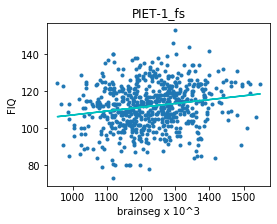

In [24]:
volume_of = 'brainseg'
hyp_name = 'PIET-1_fs'
dropnaset = ['FIQ', 'volume', 'Gender','study']

PIET_1_fs = ['brainseg', 'fiq>0','normDev', 'fs'] # 'bvol','ants','abide']
PIET_1_fs_df = apply_cond(hie, condic, PIET_1_fs, dropnaset=dropnaset, 
                          columns={'volume':volume_of})
print('len(PIET_1_fs_df)',len(PIET_1_fs_df))

resdic = run_hyp(PIET_1_fs_df, hyp_name, PIET_1_fs, ['FIQ', volume_of, 'study'], 
                 resdic={}, correctfor = ['study'], print_dir=figure_dir, debug=False)

#print(np.corrcoef(PIET_1_fs_df['FIQ'],PIET_1_fs_df['brainseg'])[0,1])
#print(resdic[hyp_name])
# plt.plot(PIET_1_fs_df['FIQ'])

In [25]:
volume_of = 'fsl_brainvol'
hyp_name = 'PIET-1_fsl'

PIET_1_fsl = ['fiq>0','normDev', 'fsl']
fsl_gm = PIET_1_fsl + ['gmfsl'] #
fsl_wm = PIET_1_fsl + ['wmfsl'] #
fsl_csf = PIET_1_fsl + ['csffsl'] #

fsl_gm_df = apply_cond(hie, condic, fsl_gm, dropnaset=dropnaset, columns={'volume':'fsl_gm'})
fsl_wm_df = apply_cond(hie, condic, fsl_wm, dropnaset=dropnaset, columns={'volume':'fsl_wm'})
fsl_csf_df = apply_cond(hie, condic, fsl_csf, dropnaset=dropnaset, columns={'volume':'fsl_csf'})

fsl_total = pd.merge(left=fsl_gm_df, right=fsl_wm_df[['ID','fsl_wm']], left_on='ID', right_on='ID')
fsl_total = pd.merge(left=fsl_total, right=fsl_csf_df[['ID','fsl_csf']], left_on='ID', right_on='ID')
fsl_total['fsl_brainvol'] = fsl_total['fsl_csf'] + fsl_total['fsl_wm'] + fsl_total['fsl_gm']
print('len(fsl_total)',len(fsl_total))


len(fsl_total) 649


{'P>|t|': ' 0.004', 't': '    2.885', 'rsquared_adj': '0.0781', 'nobs': '649', 'conditions': ['fiq>0', 'normDev', 'fsl'], 'variables': ['FIQ', 'fsl_brainvol', 'study'], 'ccoef_orig': 0.11196484989530606, 'ccoef_corr': 0.10880904248554282, 'correct_shape': (649, 25), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f6526089e10>), 'fig_fname': 'PIET-1_fsl2020-04-15-04-47-29.png'}


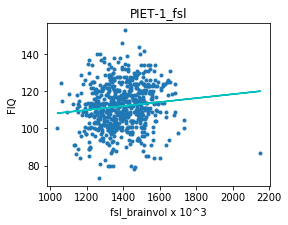

In [26]:
resdic = run_hyp(fsl_total, hyp_name, PIET_1_fsl, ['FIQ', volume_of, 'study'], resdic=resdic, 
                 correctfor = ['study'], print_dir=figure_dir, debug=False)
print(resdic[hyp_name])

##### and with ANTS ?


len(PIET_1_ants_df) 542
{'P>|t|': ' 0.000', 't': '    3.869', 'rsquared_adj': '0.0964', 'nobs': '542', 'conditions': ['bvol', 'fiq>0', 'normDev', 'ants'], 'variables': ['FIQ', 'ants_brainvol', 'study'], 'ccoef_orig': 0.17101918710267835, 'ccoef_corr': 0.1580978211293806, 'correct_shape': (542, 22), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f652607f908>), 'fig_fname': 'PIET-1_ants2020-04-15-04-47-29.png'}


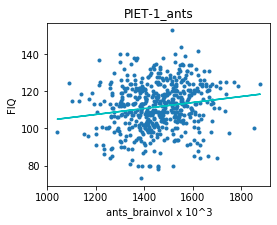

In [27]:
volume_of = 'ants_brainvol'
hyp_name = 'PIET-1_ants'
PIET_1_ants = ['bvol', 'fiq>0', 'normDev', 'ants']
PIET_1_ants_df = apply_cond(hie, condic, PIET_1_ants, dropnaset=dropnaset, columns={'volume':'ants_brainvol'})
print('len(PIET_1_ants_df)',len(PIET_1_ants_df))

resdic = run_hyp(PIET_1_ants_df, hyp_name, PIET_1_ants, ['FIQ', volume_of, 'study'], 
                 correctfor = ['study'], print_dir=figure_dir, resdic=resdic, debug=False)
print(resdic[hyp_name])

### MAC-1: Left striatum volume (caudate + putamen) will positively correlate with IQ in the total (male + female) child (age < 20) group.


#### Create df and conditions for left striatum, **all age all gender**

In [28]:
cond_mac = ['fiq>0', 'normDev', 'left'] # , 'fs' ,'age<20', 

mac1_caud = cond_mac + ['caudate'] #
mac1_put = cond_mac + ['putamen'] #
# mac1_tiv = cond_mac + ['fiq>0','normDev','fs','TIV'] #

left_caud = apply_cond(hie, condic, mac1_caud, dropnaset=dropnaset, columns={'volume':'caudate'})
print(len(left_caud), len(left_caud[(left_caud['tool']==tooldic['surfer'])] )) 

left_put = apply_cond(hie, condic, mac1_put, dropnaset=dropnaset, columns={'volume':'putamen'})
print(len(left_put), len(set(left_put['ID'])))

#left_caud.head(7)

1845 654
1845 663


1845
1831


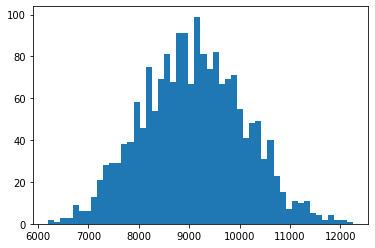

In [29]:
left_stria = pd.merge(left=left_caud, right=left_put[['ID','putamen','tool']], on=['ID','tool'])
left_stria['striatum'] = left_stria['caudate'] + left_stria['putamen']
print(len(left_stria))

left_stria.head(3)

left_stria = left_stria[(left_stria['striatum'] > 6000) & (left_stria['striatum'] < 13000)]
print(len(left_stria))
_ = plt.hist(left_stria['striatum'],50)


In [30]:
left_stria_condic = define_conditions(left_stria, tooldic=tooldic, 
                                      normalDev=normalDev, patient=patient, h2ube=h2ube)

#print((set(left_stria['dx'])))

### MAC-1: Left striatum volume (caudate + putamen) will positively correlate with IQ in the total (male + female) child (age < 20) group.


#### FS

In [31]:
print(list(left_stria))

['study', 'ID', 'Age', 'dx', 'Gender', 'FIQ', 'PIQ', 'VIQ', 'tool', 'softwareLabel', 'structure', 'laterality', 'caudate', 'putamen', 'striatum']


535
{'P>|t|': ' 0.000', 't': '    4.827', 'rsquared_adj': '0.115', 'nobs': '535', 'conditions': ['fiq>0', 'normDev', 'left', 'age<20', 'fs'], 'variables': ['FIQ', 'striatum_fs', 'study'], 'ccoef_orig': 0.22048695728438614, 'ccoef_corr': 0.19651736867363895, 'correct_shape': (535, 20), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f652582d208>), 'fig_fname': 'MAC-1-fs2020-04-15-04-47-30.png'}


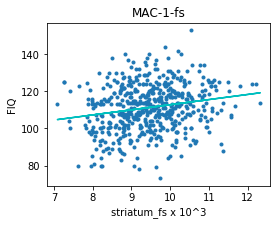

In [32]:
volume_of = 'striatum_fs'
hyp_name = 'MAC-1-fs'
mac1_child_fs = ['age<20','fs']
mac1_child_df = apply_cond(left_stria, left_stria_condic, mac1_child_fs, columns={'striatum':'striatum_fs'})
print(len(mac1_child_df))
# print(list(mac1_child_df))
resdic = run_hyp(mac1_child_df, hyp_name, cond_mac+mac1_child_fs, ['FIQ', volume_of, 'study'], 
                 correctfor = ['study'], print_dir=figure_dir, resdic=resdic, debug=False)

print(resdic[hyp_name])

#### FSL

517
{'P>|t|': ' 0.000', 't': '    5.031', 'rsquared_adj': '0.13', 'nobs': '517', 'conditions': ['fiq>0', 'normDev', 'left', 'age<20', 'fsl'], 'variables': ['FIQ', 'striatum_fsl', 'study'], 'ccoef_orig': 0.2176417723091896, 'ccoef_corr': 0.2065270595695553, 'correct_shape': (517, 21), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f65257998d0>), 'fig_fname': 'MAC-1-fsl2020-04-15-04-47-31.png'}


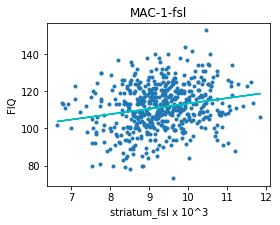

In [33]:
volume_of = 'striatum_fsl'
hyp_name = 'MAC-1-fsl'
mac1_child_fsl = ['age<20','fsl']
mac1_child_df = apply_cond(left_stria, left_stria_condic, mac1_child_fsl, 
                                                          columns={'striatum':'striatum_fsl'})
print(len(mac1_child_df))

resdic = run_hyp(mac1_child_df, hyp_name, cond_mac+mac1_child_fsl, ['FIQ', volume_of, 'study'], 
                 correctfor = ['study'], print_dir=figure_dir, resdic=resdic, debug=False)

print(resdic[hyp_name])

In [34]:
volume_of = 'striatum_ants'
hyp_name = 'MAC-1-ants'
mac1_child_ants = ['age<20','ants'] #,'abide']
mac1_child_df = apply_cond(left_stria, left_stria_condic, mac1_child_ants, 
                                                          columns={'striatum':'striatum_ants'})
print(len(mac1_child_df)) # list(mac1_child_df)
assert(len(mac1_child_df) == len(set(mac1_child_df['ID'])))
# mac1_child_df.head(5)

488


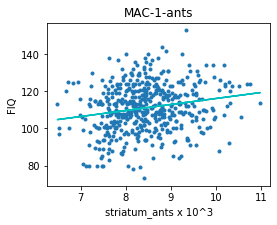

In [35]:
resdic = run_hyp(mac1_child_df, hyp_name, cond_mac+mac1_child_ants, 
                     ['FIQ', volume_of, 'study'], correctfor = ['study'], print_dir=figure_dir, 
                     resdic=resdic, debug=False)

# print(resdic)

### MAC-2: Left striatum volume (caudate + putamen) will positively correlate with IQ in the male children group.


405
{'P>|t|': ' 0.000', 't': '    4.536', 'rsquared_adj': '0.133', 'nobs': '405', 'conditions': ['fiq>0', 'normDev', 'left', 'age<20', 'male', 'fs'], 'variables': ['FIQ', 'striatum', 'study'], 'ccoef_orig': 0.2291351356088509, 'ccoef_corr': 0.2101360129917002, 'correct_shape': (405, 20), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f65256c4a90>), 'fig_fname': 'MAC-2-fs2020-04-15-04-47-31.png'}


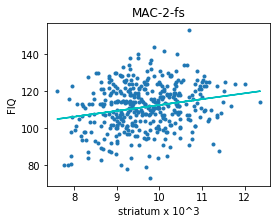

In [36]:
sftw = 'fs'
volume_of = 'striatum'
hyp_name = 'MAC-2-' + sftw
mac2_cond = ['age<20','male', sftw]
mac2_df = apply_cond(left_stria, left_stria_condic, mac2_cond)
print(len(mac2_df))

resdic = run_hyp(mac2_df, hyp_name, cond_mac+mac2_cond, 
                     ['FIQ', volume_of, 'study'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)

print(resdic[hyp_name])

#### MAC-2 ANTS

#### MAC-2 FSL

391
{'P>|t|': ' 0.000', 't': '    4.614', 'rsquared_adj': '0.144', 'nobs': '391', 'conditions': ['fiq>0', 'normDev', 'left', 'age<20', 'male', 'fsl'], 'variables': ['FIQ', 'striatum', 'study'], 'ccoef_orig': 0.2138868022924166, 'ccoef_corr': 0.21613716765690666, 'correct_shape': (391, 21), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f65256ae198>), 'fig_fname': 'MAC-2-fsl2020-04-15-04-47-32.png'}


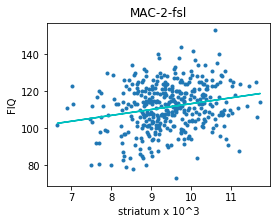

In [37]:
sftw = 'fsl'
volume_of = 'striatum'
hyp_name = 'MAC-2-' + sftw
mac2_cond = ['age<20','male', sftw]
mac2_df = apply_cond(left_stria, left_stria_condic, mac2_cond)
print(len(mac2_df))

resdic = run_hyp(mac2_df, hyp_name, cond_mac+mac2_cond, 
                     ['FIQ', volume_of, 'study'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)

print(resdic[hyp_name])

365
{'P>|t|': ' 0.000', 't': '    4.062', 'rsquared_adj': '0.136', 'nobs': '365', 'conditions': ['fiq>0', 'normDev', 'left', 'age<20', 'male', 'ants'], 'variables': ['FIQ', 'striatum', 'study'], 'ccoef_orig': 0.24472899043649016, 'ccoef_corr': 0.19786310979567473, 'correct_shape': (365, 19), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f65256d4e48>), 'fig_fname': 'MAC-2-ants2020-04-15-04-47-32.png'}


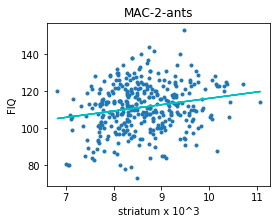

In [38]:
sftw = 'ants'
volume_of = 'striatum'
hyp_name = 'MAC-2-' + sftw
mac2_cond = ['age<20','male', sftw]

mac2_df = apply_cond(left_stria, left_stria_condic, mac2_cond)
print(len(mac2_df))

resdic = run_hyp(mac2_df, hyp_name, cond_mac+mac2_cond, 
                     ['FIQ', volume_of, 'study'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)

print(resdic[hyp_name])

### MAC-3: Left striatum volume (caudate + putamen) will not correlate with IQ in the female children group.


#### MAC-3 FS

130
{'P>|t|': ' 0.017', 't': '    2.428', 'rsquared_adj': '0.105', 'nobs': '130', 'conditions': ['fiq>0', 'normDev', 'left', 'age<20', 'female', 'fs'], 'variables': ['FIQ', 'striatum', 'study'], 'ccoef_orig': 0.22104031833831084, 'ccoef_corr': 0.20229083851366958, 'correct_shape': (130, 15), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f65255cbcf8>), 'fig_fname': 'MAC-3-fs2020-04-15-04-47-32.png'}


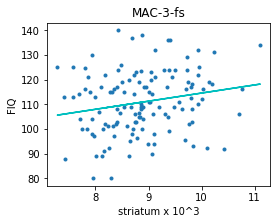

In [39]:
sftw = 'fs'
volume_of = 'striatum'
hyp_name = 'MAC-3-' + sftw
hyp_cond = ['age<20','female', sftw]
hyp_df = apply_cond(left_stria, left_stria_condic, hyp_cond)
print(len(hyp_df))

resdic = run_hyp(hyp_df, hyp_name, cond_mac+hyp_cond, 
                     ['FIQ', volume_of, 'study'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)

print(resdic[hyp_name])

#### MAC-3 FSL

126
{'P>|t|': ' 0.010', 't': '    2.626', 'rsquared_adj': '0.144', 'nobs': '126', 'conditions': ['fiq>0', 'normDev', 'left', 'age<20', 'female', 'fsl'], 'variables': ['FIQ', 'striatum', 'study'], 'ccoef_orig': 0.24789886533675384, 'ccoef_corr': 0.21728553567770245, 'correct_shape': (126, 15), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f65255a27b8>), 'fig_fname': 'MAC-3-fsl2020-04-15-04-47-33.png'}


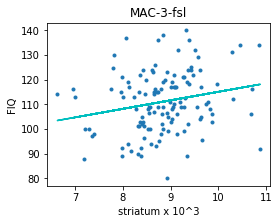

In [40]:
sftw = 'fsl'
volume_of = 'striatum'
hyp_name = 'MAC-3-' + sftw
hyp_cond = ['age<20','female', sftw]
hyp_df = apply_cond(left_stria, left_stria_condic, hyp_cond)
print(len(hyp_df))

resdic = run_hyp(hyp_df, hyp_name, cond_mac+hyp_cond, 
                     ['FIQ', volume_of, 'study'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)

print(resdic[hyp_name])

#### MAC-3 ANTS

123
{'P>|t|': ' 0.020', 't': '    2.368', 'rsquared_adj': '0.0927', 'nobs': '123', 'conditions': ['fiq>0', 'normDev', 'left', 'age<20', 'female', 'ants'], 'variables': ['FIQ', 'striatum', 'study'], 'ccoef_orig': 0.20295296128345905, 'ccoef_corr': 0.20421804634667362, 'correct_shape': (123, 14), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f652550a588>), 'fig_fname': 'MAC-3-ants2020-04-15-04-47-33.png'}


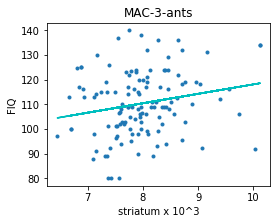

In [41]:
sftw = 'ants'
volume_of = 'striatum'
hyp_name = 'MAC-3-' + sftw # + 'abide'
hyp_cond = ['age<20','female', sftw] #, 'abide']
hyp_df = apply_cond(left_stria, left_stria_condic, hyp_cond)
print(len(hyp_df))

resdic = run_hyp(hyp_df, hyp_name, cond_mac+hyp_cond, 
                     ['FIQ', volume_of, 'study'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)

print(resdic[hyp_name])

### compute cc and tbv  for GANJ, no age or gender condition 

In [42]:
condic = define_conditions(hie, tooldic=tooldic, normalDev=normalDev, patient=patient, h2ube=h2ube)
condic.keys()
print(list(hie))

['study', 'ID', 'Age', 'dx', 'Gender', 'FIQ', 'PIQ', 'VIQ', 'tool', 'softwareLabel', 'structure', 'laterality', 'volume']


In [43]:
"""
sftw = 'fs'
hyp_Ganj = ['fiq>0','normDev', sftw] #, 'adhd200']# , 'adhd' ,'abide','age<20'

hyp_ccant = hyp_Ganj + ['ccant'] #
hyp_cccen = hyp_Ganj + ['cccen'] #
hyp_ccpos = hyp_Ganj + ['ccpos'] #

ccant = apply_cond(hie, condic, hyp_ccant, dropnaset=dropnaset, columns={'volume':'ccant'})
cccen = apply_cond(hie, condic, hyp_cccen, dropnaset=dropnaset, columns={'volume':'cccen'})
ccpos = apply_cond(hie, condic, hyp_ccpos, dropnaset=dropnaset, columns={'volume':'ccpos'})

# Note: Only freesurfer measures CC_* therefore no need to merge on tools as well
cc_df = pd.merge(left=ccant, right=cccen[['ID','cccen']], on=['ID']) #,'tools']) # left_on='ID', right_on='ID')
cc_df = pd.merge(left=cc_df, right=ccpos[['ID','ccpos']], on=['ID']) #,'tools']) # left_on='ID', right_on='ID')

cc_df['cc'] = cc_df['ccant']+cc_df['cccen']+cc_df['ccpos']
len(cc_df), len(ccant), len(cccen), len(ccpos)
# (654, 654, 654, 654)
""";

In [44]:
sftw = 'fs'
hyp_Ganj = ['fiq>0','normDev', sftw] #, 'adhd200']# , 'adhd' ,'abide','age<20'
cond_ccfs = hyp_Ganj+['ccfs']
cond_ccfs_df = apply_cond(hie, condic, cond_ccfs)

# print(set(ccfs['softwareLabel']))
# 
cc_df = split_op_merge(cond_ccfs_df, index='ID', col='softwareLabel', values='volume', newcol='cc', 
                        keepcols=['study', 'Age', 'Gender'], verbose=True) # , 'Age', 'dx', 'Gender', 'FIQ'])

len(df):  3270
tmp_cols:  ['CC_Central Volume_mm3 (mm^3)', 'CC_Posterior Volume_mm3 (mm^3)', 'CC_Mid_Anterior Volume_mm3 (mm^3)', 'CC_Mid_Posterior Volume_mm3 (mm^3)', 'CC_Anterior Volume_mm3 (mm^3)']
len(df.dropduplicates):  3270
len(newdf:  654
after merge and dropna len(newdf):  654


In [45]:
tmp_df = cc_df[cc_df['study'].str.contains("ADHD")]
print('664 - len(tmp_df): ', 664 - len(tmp_df))
#tmp_df.head(3)
del tmp_df

664 - len(tmp_df):  493


In [46]:
hyp_ganj = 'GANJ-'

hyp_gm = hyp_Ganj + ['gm','latNan'] # + ['adhd200']#
gm = apply_cond(hie, condic, hyp_gm, dropnaset=dropnaset, columns={'volume':'gm'})
print(gm[['ID','gm','laterality']].head(2),len(gm))

hyp_wm = hyp_Ganj + ['wm','latNan'] #
wm = apply_cond(hie, condic, hyp_wm, dropnaset=dropnaset, columns={'volume':'wm'})
print(wm[['ID','wm','laterality']].head(2),len(wm))

hyp_csf = hyp_Ganj + ['csf','latNan'] #
csf = apply_cond(hie, condic, hyp_csf, dropnaset=dropnaset, columns={'volume':'csf'})
print(csf[['ID','csf','laterality']].head(2),len(csf))

tbv = pd.merge(left=gm, right=wm[['ID','wm']], left_on='ID', right_on='ID')
tbv = pd.merge(left=tbv, right=csf[['ID','csf']], left_on='ID', right_on='ID')
tbv['tbv'] = tbv['wm'] + tbv['gm'] +  tbv['csf']
tbv.drop(['wm','gm','csf'], axis=1, inplace=True)

print(len(gm), len(wm), len(csf), len(tbv))

        ID        gm laterality
114  50665  664628.7        NaN
145  50666  834042.3        NaN 654
        ID        wm laterality
109  50665  440221.8        NaN
140  50666  651926.1        NaN 654
        ID     csf laterality
6    50666  1366.8        NaN
281  50665   735.7        NaN 654
654 654 654 654


In [47]:
cc_tbv = pd.merge(left=tbv, right=cc_df[['ID','cc']], left_on='ID', right_on='ID')
condic_cc_tbv = define_conditions(cc_tbv, tooldic=tooldic, normalDev=normalDev, patient=patient, h2ube=h2ube)

In [48]:
list(cc_tbv)

['study',
 'ID',
 'Age',
 'dx',
 'Gender',
 'FIQ',
 'PIQ',
 'VIQ',
 'tool',
 'softwareLabel',
 'structure',
 'laterality',
 'tbv',
 'cc']

### GANJ-0a Corpus Callosum Area vs. Total Brain Volume covary for site
### GANJ-0b Corpus Callosum Area vs. Age, covary for site

{'P>|t|': ' 0.000', 't': '   12.983', 'rsquared_adj': '0.419', 'nobs': '654', 'conditions': ['fiq>0', 'normDev', 'fs'], 'variables': ['cc', 'tbv', 'study'], 'ccoef_orig': 0.47920121143093486, 'ccoef_corr': 0.38735504769604484, 'correct_shape': (654, 25), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f6525447978>), 'fig_fname': 'GANJ-0a_cc_tbv2020-04-15-04-47-34.png'}
{'P>|t|': ' 0.000', 't': '   12.983', 'rsquared_adj': '0.304', 'nobs': '654', 'conditions': ['fiq>0', 'normDev', 'fs'], 'variables': ['tbv', 'cc', 'study'], 'ccoef_orig': 0.47920121143093486, 'ccoef_corr': 0.4237039565890662, 'correct_shape': (654, 25), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f65254b1cf8>), 'fig_fname': 'GANJ-0a_tbv_cc2020-04-15-04-47-34.png'}
{'P>|t|': ' 0.213', 't': '    1.247', 'rsquared_adj': '0.265', 'nobs': '654', 'conditions': ['fiq>0',

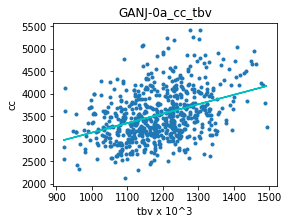

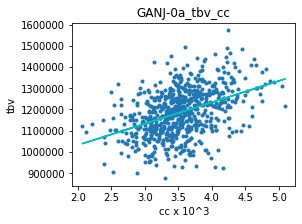

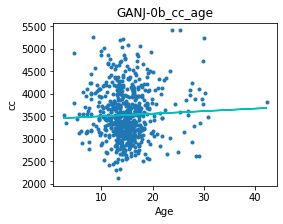

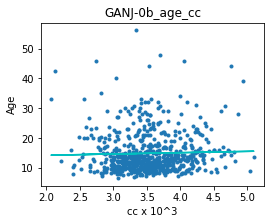

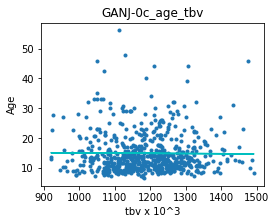

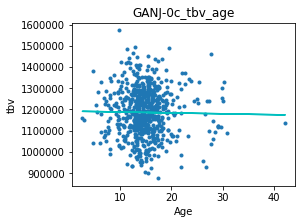

In [49]:
volume_of = 'cc'
hyp_df =  cc_tbv

hyp_name = hyp_ganj + '0a_cc_tbv'
#print(len(hyp_df))
resdic = run_hyp(hyp_df, hyp_name, hyp_Ganj, 
                     [ volume_of, 'tbv', 'study'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)
print(resdic[hyp_name])

hyp_name = hyp_ganj + '0a_tbv_cc'
resdic = run_hyp(hyp_df, hyp_name, hyp_Ganj, 
                     ['tbv',  volume_of, 'study'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)
print(resdic[hyp_name])

hyp_name = hyp_ganj + '0b_cc_age'
resdic = run_hyp(hyp_df, hyp_name, hyp_Ganj, 
                     [volume_of, 'Age', 'study'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)
print(resdic[hyp_name])

hyp_name = hyp_ganj + '0b_age_cc'
resdic = run_hyp(hyp_df, hyp_name, hyp_Ganj, 
                     ['Age', volume_of, 'study'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)
print(resdic[hyp_name])

hyp_name = hyp_ganj + '0c_age_tbv'
resdic = run_hyp(hyp_df, hyp_name, hyp_Ganj, 
                     ['Age', 'tbv', 'study'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)
print(resdic[hyp_name])

hyp_name = hyp_ganj + '0c_tbv_age'
resdic = run_hyp(hyp_df, hyp_name, hyp_Ganj, 
                     ['tbv', 'Age', 'study'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)
print(resdic[hyp_name])

### GANJ-1: Total Corpus Callosum midsagittal area, after correcting for total brain volume, will negatively correlate with IQ.


535
{'P>|t|': ' 0.822', 't': '    0.225', 'rsquared_adj': '0.108', 'nobs': '535', 'conditions': ['fiq>0', 'normDev', 'fs', 'age<20'], 'variables': ['FIQ', 'cc', 'study + tbv'], 'ccoef_orig': 0.040293679451181445, 'ccoef_corr': 0.09290138503723235, 'correct_shape': (535, 20), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f652531f3c8>), 'fig_fname': 'GANJ-12020-04-15-04-47-36.png'}


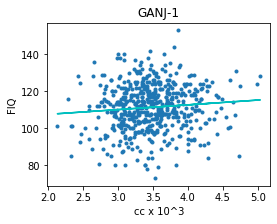

In [50]:
volume_of = 'cc'
hyp_name = hyp_ganj + '1' # + 'abide'
hyp_cond = ['age<20'] #'fiq>0','normDev','fs','age<=20','ccant'] #
hyp_df = apply_cond(cc_tbv, condic_cc_tbv, hyp_cond)
print(len(hyp_df))

resdic = run_hyp(hyp_df, hyp_name, hyp_Ganj+hyp_cond, 
                     ['FIQ', volume_of, 'study + tbv'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)
print(resdic[hyp_name])

### GANJ-2: Total Corpus Callosum midsagittal area, after correcting for total brain volume, will negatively correlate with IQ in the young (age < 12) group.

270
{'P>|t|': ' 0.585', 't': '    0.547', 'rsquared_adj': '0.0926', 'nobs': '270', 'conditions': ['fiq>0', 'normDev', 'fs', 'age<12'], 'variables': ['FIQ', 'cc', 'study + tbv'], 'ccoef_orig': 0.038639062365120644, 'ccoef_corr': 0.08533704976406371, 'correct_shape': (270, 17), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f65251dab00>), 'fig_fname': 'GANJ-22020-04-15-04-47-37.png'}


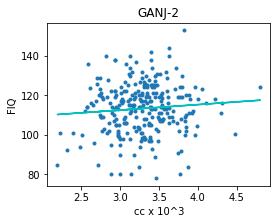

In [51]:
volume_of = 'cc'
hyp_name = hyp_ganj + '2' # + 'abide'
hyp_cond = ['age<12'] #'fiq>0','normDev','fs','age<=20','ccant'] #
hyp_df = apply_cond(cc_tbv, condic_cc_tbv, hyp_cond)
print(len(hyp_df))

resdic = run_hyp(hyp_df, hyp_name, hyp_Ganj+hyp_cond, 
                     ['FIQ', volume_of, 'study + tbv'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)
print(resdic[hyp_name])

### GANJ-3: Total Corpus Callosum midsagittal area, after correcting for total brain volume, will not significantly correlate with IQ in the adolescent (age > 12) group.


384
{'P>|t|': ' 0.886', 't': '   -0.143', 'rsquared_adj': '0.0917', 'nobs': '384', 'conditions': ['fiq>0', 'normDev', 'fs', 'age>=12'], 'variables': ['FIQ', 'cc', 'study + tbv'], 'ccoef_orig': 0.1627096393412281, 'ccoef_corr': 0.09477868560848252, 'correct_shape': (384, 24), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f652514d5f8>), 'fig_fname': 'GANJ-32020-04-15-04-47-37.png'}


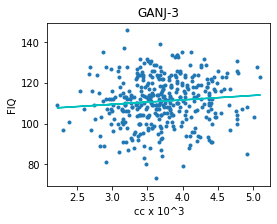

In [52]:
volume_of = 'cc'
hyp_name = hyp_ganj + '3' # + 'abide'
hyp_cond = ['age>=12'] #'fiq>0','normDev','fs','age<=20','ccant'] #
hyp_df = apply_cond(cc_tbv, condic_cc_tbv, hyp_cond)
print(len(hyp_df))

resdic = run_hyp(hyp_df, hyp_name, hyp_Ganj+hyp_cond, 
                     ['FIQ', volume_of, 'study + tbv'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)
print(resdic[hyp_name])

### GANJ-4:. Total Corpus Callosum midsagittal area, after correcting for total brain volume, will negatively correlate with IQ in the male (age < 12) group.


191
{'P>|t|': ' 0.224', 't': '    1.221', 'rsquared_adj': '0.122', 'nobs': '191', 'conditions': ['fiq>0', 'normDev', 'fs', 'age<12', 'male'], 'variables': ['FIQ', 'cc', 'study + tbv'], 'ccoef_orig': 0.0565207668719081, 'ccoef_corr': 0.13997589274393787, 'correct_shape': (191, 16), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f65251acf98>), 'fig_fname': 'GANJ-42020-04-15-04-47-37.png'}


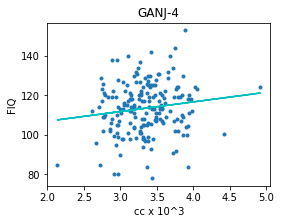

In [53]:
volume_of = 'cc'
hyp_name = hyp_ganj + '4' # + 'abide'
hyp_cond = ['age<12','male'] #'fiq>0','normDev','fs','age<=20','ccant'] #
hyp_df = apply_cond(cc_tbv, condic_cc_tbv, hyp_cond)
print(len(hyp_df))

resdic = run_hyp(hyp_df, hyp_name, hyp_Ganj+hyp_cond, 
                     ['FIQ', volume_of, 'study + tbv'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)
print(resdic[hyp_name])

### GANJ-5: Total Corpus Callosum midsagittal area, after correcting for total brain volume, will not significantly correlate with IQ in the female (age < 12) group.


79
{'P>|t|': ' 0.698', 't': '   -0.390', 'rsquared_adj': '-0.0325', 'nobs': ' 79', 'conditions': ['fiq>0', 'normDev', 'fs', 'age<12', 'female'], 'variables': ['FIQ', 'cc', 'study + tbv'], 'ccoef_orig': -0.012727593491354851, 'ccoef_corr': -0.012412172934946585, 'correct_shape': (79, 11), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f65250eada0>), 'fig_fname': 'GANJ-52020-04-15-04-47-38.png'}


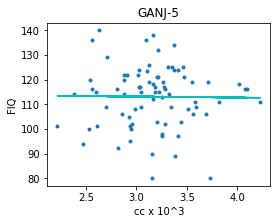

In [54]:
volume_of = 'cc'
hyp_name = hyp_ganj + '5' 
hyp_cond = ['age<12','female'] # ,'abide', 'fiq>0','normDev','fs','age<=20','ccant'] #
hyp_df = apply_cond(cc_tbv, condic_cc_tbv, hyp_cond)
print(len(hyp_df))

resdic = run_hyp(hyp_df, hyp_name, hyp_Ganj+hyp_cond, 
                     ['FIQ', volume_of, 'study + tbv'], resdic=resdic, 
                     correctfor = ['study'], print_dir=figure_dir, debug=False)
print(resdic[hyp_name])

In [55]:
# print(resdic)
lhyp = list(resdic.keys())
hyp = ['hyp'] + lhyp

print(hyp)
col_names = list(resdic[lhyp[0]].keys())
print(col_names)

print(resdic['MAC-3-fsl'])

['hyp', 'PIET-1_fs', 'PIET-1_fsl', 'PIET-1_ants', 'MAC-1-fs', 'MAC-1-fsl', 'MAC-1-ants', 'MAC-2-fs', 'MAC-2-fsl', 'MAC-2-ants', 'MAC-3-fs', 'MAC-3-fsl', 'MAC-3-ants', 'GANJ-0a_cc_tbv', 'GANJ-0a_tbv_cc', 'GANJ-0b_cc_age', 'GANJ-0b_age_cc', 'GANJ-0c_age_tbv', 'GANJ-0c_tbv_age', 'GANJ-1', 'GANJ-2', 'GANJ-3', 'GANJ-4', 'GANJ-5']
['P>|t|', 't', 'rsquared_adj', 'nobs', 'conditions', 'variables', 'ccoef_orig', 'ccoef_corr', 'correct_shape', 'correct_names', 'figure', 'fig_fname']
{'P>|t|': ' 0.010', 't': '    2.626', 'rsquared_adj': '0.144', 'nobs': '126', 'conditions': ['fiq>0', 'normDev', 'left', 'age<20', 'female', 'fsl'], 'variables': ['FIQ', 'striatum', 'study'], 'ccoef_orig': 0.24789886533675384, 'ccoef_corr': 0.21728553567770245, 'correct_shape': (126, 15), 'correct_names': ['study'], 'figure': (<Figure size 288x216 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f65255a27b8>), 'fig_fname': 'MAC-3-fsl2020-04-15-04-47-33.png'}


In [56]:
datares = []
lhyp = list(resdic.keys())
hyp = ['hyp'] + lhyp

col_names = list(resdic[lhyp[0]].keys())
for idx, col in enumerate(col_names):
    if not col == 'figure':
        datares.append( [col] + [resdic[h][col] for h in lhyp]  )

datares = [hyp] + datares
resdf = pd.DataFrame.from_records(datares).transpose()
resdf.head(50)

,0,1,2,3,4,5,6,7,8,9,10,11
0,hyp,P>|t|,t,rsquared_adj,nobs,conditions,variables,ccoef_orig,ccoef_corr,correct_shape,correct_names,fig_fname
1,PIET-1_fs,0.000,4.866,0.0986,654,"[brainseg, fiq>0, normDev, fs]","[FIQ, brainseg, study]",0.189408,0.180793,"(654, 25)",[study],PIET-1_fs2020-04-15-04-47-29.png
2,PIET-1_fsl,0.004,2.885,0.0781,649,"[fiq>0, normDev, fsl]","[FIQ, fsl_brainvol, study]",0.111965,0.108809,"(649, 25)",[study],PIET-1_fsl2020-04-15-04-47-29.png
3,PIET-1_ants,0.000,3.869,0.0964,542,"[bvol, fiq>0, normDev, ants]","[FIQ, ants_brainvol, study]",0.171019,0.158098,"(542, 22)",[study],PIET-1_ants2020-04-15-04-47-29.png
4,MAC-1-fs,0.000,4.827,0.115,535,"[fiq>0, normDev, left, age<20, fs]","[FIQ, striatum_fs, study]",0.220487,0.196517,"(535, 20)",[study],MAC-1-fs2020-04-15-04-47-30.png
5,MAC-1-fsl,0.000,5.031,0.13,517,"[fiq>0, normDev, left, age<20, fsl]","[FIQ, striatum_fsl, study]",0.217642,0.206527,"(517, 21)",[study],MAC-1-fsl2020-04-15-04-47-31.png
6,MAC-1-ants,0.000,4.617,0.117,488,"[fiq>0, normDev, left, age<20, ants]","[FIQ, striatum_ants, study]",0.233701,0.196544,"(488, 19)",[study],MAC-1-ants2020-04-15-04-47-31.png
7,MAC-2-fs,0.000,4.536,0.133,405,"[fiq>0, normDev, left, age<20, male, fs]","[FIQ, striatum, study]",0.229135,0.210136,"(405, 20)",[study],MAC-2-fs2020-04-15-04-47-31.png
8,MAC-2-fsl,0.000,4.614,0.144,391,"[fiq>0, normDev, left, age<20, male, fsl]","[FIQ, striatum, study]",0.213887,0.216137,"(391, 21)",[study],MAC-2-fsl2020-04-15-04-47-32.png
9,MAC-2-ants,0.000,4.062,0.136,365,"[fiq>0, normDev, left, age<20, male, ants]","[FIQ, striatum, study]",0.244729,0.197863,"(365, 19)",[study],MAC-2-ants2020-04-15-04-47-32.png


In [57]:
timestr = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_filename = csv_filename[:-4]+'-'+timestr+'.csv'
resdf.to_csv(path_or_buf = output_filename, index=False)

In [58]:
pwd

'/home/jb/code/repronim/simple2/simple2_analysis'

### Scrap

In [59]:
"""
hyp2 = ['fiq>0','normDev','fs','age<20']
hyp2_caud = hyp2 + ['caudate'] # ,'abide']
hyp2_put = hyp2 + ['putamen'] # ,'abide']
hyp2_tiv = hyp2 + ['TIV'] # ,'abide']
tmp_caud = apply_cond(hie, condic, hyp2_caud, dropnaset=dropnaset)
caud = split_merge_df(tmp_caud, indx='ID', spliton='laterality', levels=['Left','Right'], 
                       keep_col='volume', op='+',colrename='caudate')
tmp_put = apply_cond(hie, condic, hyp2_put, dropnaset=dropnaset)
put = split_merge_df(tmp_put, indx='ID', spliton='laterality', levels=['Left','Right'], 
                       keep_col='volume', op='+',colrename='putamen')
tmp_tiv = apply_cond(hie, condic, hyp2_tiv, dropnaset=dropnaset)
print(len(caud), len(put), len(tmp_tiv))

stria = pd.merge(left=caud, right=put[['ID','putamen']], left_on='ID', right_on='ID')
stria['striatum'] = stria['caudate']+stria['putamen']
stria = pd.merge(left=stria, right=tmp_tiv[['ID','volume']], left_on='ID', right_on='ID')
stria.rename(columns={'volume':'TIV'},inplace=True)
print(list(stria),len(stria))
""";

"""
cond_mac = ['fiq>0','normDev', softw,] # ,'age<20']
mac_caud = cond_mac + ['caudate'] #
mac_put = cond_mac + ['putamen'] #
mac_tiv = cond_mac + ['fiq>0','normDev',softw,'TIV'] #

left_caud = apply_cond(hie, condic, mac_caud, dropnaset=dropnaset, columns={'volume':'caudate'})
left_put = apply_cond(hie, condic, mac_put, dropnaset=dropnaset, columns={'volume':'putamen'})

left_stria = pd.merge(left=left_caud, right=left_put[['ID','putamen']], left_on='ID', right_on='ID')
left_stria['striatum'] = left_stria['caudate'] + left_stria['putamen']
left_stria_condic = define_conditions(left_stria, tooldic=tooldic, normalDev=normalDev, adhd=adhd, h2ube=h2ube)
print(len(left_stria))

""";


""" 
iq = 'FIQ'

# md = smf.ols(iq + " ~ Q('volume') + Gender + Age + study ", data=tmp) #  
# md = smf.ols(iq + " ~ Q('striatum') + study + TIV ", data=stria) #  
md = smf.ols(iq + " ~ Q('striatum') + study ", data=mac1) #  
mdf = md.fit()
print(mdf.summary())

varname = "Q('striatum')"
hyp_name = 'MAC-1'
resdic.update(md2dic(varname, hyp_name, cond_mac+mac1_cond, mdf=mdf))
""";


"""
#ganj1 = apply_cond(cc_tbv, condic_cc_tbv, ganj1_cond)
#print(list(ganj1),len(ganj1))

#iq = 'FIQ'
# md = smf.ols(iq + " ~ Q('volume') + Gender + Age + study ", data=tmp) #  
#md = smf.ols(iq + " ~ Q('striatum') + study + TIV ", data=stria) #  
#md = smf.ols(iq + " ~ Q('cc') + study + tbv ", data=ganj1) #  
#mdf = md.fit()
#print(mdf.summary())

#varname, hyp_name = "Q('cc')",'GANJ-1'
#resdic.update(md2dic(varname, hyp_name, hypGanj+ganj1_cond, mdf=mdf))
""";

"""
ganj2_cond = ['age<12'] #'fiq>0','normDev','fs','age<=20','ccant'] #
ganj2 = apply_cond(cc_tbv, condic_cc_tbv, ganj2_cond)
print(list(ganj2),len(ganj2));

iq = 'FIQ'
# md = smf.ols(iq + " ~ Q('volume') + Gender + Age + study ", data=tmp) #  
#md = smf.ols(iq + " ~ Q('striatum') + study + TIV ", data=stria) #  
md = smf.ols(iq + " ~ Q('cc') + study + tbv ", data=ganj2) #  
mdf = md.fit()
print(mdf.summary())

varname, hyp_name = "Q('cc')",'GANJ-2'
resdic.update(md2dic(varname, hyp_name, hypGanj+ganj2_cond, mdf=mdf))
""";

"""ganj3_cond = ['age>=12'] #
ganj3 = apply_cond(cc_tbv, condic_cc_tbv, ganj3_cond)
print(len(ganj3))

iq = 'FIQ'
# md = smf.ols(iq + " ~ Q('volume') + Gender + Age + study ", data=tmp) #  
#md = smf.ols(iq + " ~ Q('striatum') + study + TIV ", data=stria) #  
md = smf.ols(iq + " ~ Q('cc') + study + tbv ", data=ganj3) #  
mdf = md.fit()
print(mdf.summary())


varname, hyp_name = "Q('cc')",'GANJ-3'
resdic.update(md2dic(varname, hyp_name, hypGanj+ganj3_cond, mdf=mdf))""";

In [60]:

# original_col_names = list(hie)
# column names are unique
# assert len(original_col_names) == len(set(original_col_names))
# print(list(hie))
#col_rename = {'federatedLabel':'structure'}
#hie.rename(columns=col_rename, inplace=True)


In [61]:
# check numbers directly, bypassing convenient functions

"""csv_filename = '2020-02-11-simple2_query_output.csv'
relative_dir = './data'
relative_path_filename = osp.join(relative_dir, csv_filename)
assert osp.exists(relative_path_filename)

hie = pd.read_csv(relative_path_filename, na_values='nd') #, low_memory=False)set(hie['study'])

htmp = hie[(hie['study'].str.contains("ADHD"))]
_adhd = len(set(htmp['ID']))
htmp = hie[(hie['study'].str.contains("ABIDE"))]
_abide = len(set(htmp['ID']))

print(len(set(hie['ID'])))
print(_adhd, _abide, _adhd + _abide)
""";

In [62]:
"""
condic = define_conditions(hie, tooldic=tooldic, normalDev=normalDev, patient=patient, h2ube=h2ube)
condic.keys()
print(list(hie))
# hyp_cond = ['age<20','female', 'adhd200' ]
hyp_cond = ['adhd200' ]
hyp_df = apply_cond(hie, condic, hyp_cond)
print(len(hyp_df))
len(set(hyp_df['ID']))
""";

In [63]:
"""
def split_merge_df(df, indx='ID', spliton='laterality', levels=['Left','Right'], 
                       keep_col='volume', op='+', colrename=None):
    """
    1. split the df according to 2 (n?) levels of "spliton"
    2. merge the 2 (n?) dataframes using indx as index
    3. keep only "keep_col" for the right temporary dataframe
    4. perform operation 'op' on the columns "keep_col" and name it 
       'keep_col'+'_'+ levels[0] + op + levels[1]    
    
    Was developed for adding volumes in right and left structures
    """
    
    dflev1 = df[df[spliton]==levels[0]]
    dflev2 = df[df[spliton]==levels[1]] 

    # check that the new dfs have no duplicates in the indx

    assert set(dflev1[indx]) == set(dflev2[indx])
    assert len(set(dflev1[indx])) == len(dflev1[indx])
    
    # assert len(set(dflev2[indx])) == len(dflev2[indx])
    # suffixes=('_l','_r')
    merged_inner = pd.merge(left=dflev1, right=dflev2[[indx,keep_col]], 
                            left_on=indx, right_on=indx, suffixes=levels, how='inner')
#    merged_inner.rename(columns={cols+'_x': cols+'_'+lev1, cols+'_y': cols+'_'+lev2}, inplace=True)

    # sum keep_col values in a new column
    add_col_name = keep_col + levels[0] + op + levels[1]
    if op == '+':
        merged_inner[add_col_name] = \
                        merged_inner[keep_col+levels[0]] + merged_inner[keep_col+levels[1]]  
    if colrename is not None:
        merged_inner.rename(columns={add_col_name:colrename}, inplace=True)
    return merged_inner
"""

"""
    if droplist != []:
        for colname in droplist:
            colname_y = colname + '_y'
            colname_x = colname + '_x'
            merged_inner.drop(colname_y, axis=1, inplace=True)
            merged_inner.rename(columns={colname_x: colname}, inplace=True)
""";

IndentationError: unexpected indent (<ipython-input-63-7f7b181c75ab>, line 5)

In [ ]:
"""
def pivot_and_add(df, index, columns, values, add_col, keep_cols):
    """
    index: will be the index of the returned df
    columns: return df will be "wide" based on the values of columns
    values: content of the wide df
    add_col: name of the column where values of columns are added
    keep_cols: list of column names to keep
    
    """
    # index='ID', columns='softwareLabel', values='volume'
    
    add_cols = list(set(df[columns])) # find values in columns
    df.drop_duplicates([index, columns, values], inplace=True)
    newdf = df.pivot(index=index, columns=columns, values=values).dropna()
    newdf.reset_index() # put the index, 'ID' here, back in a column
    newdf[add_col] = newdf.loc[:,add_cols].sum(axis=1)
    newdf.drop(add_cols, axis=1, inplace=True)
    
    assert not ('ID' in keep_cols)
    
    # now, create a df with keep_cols:
    keepdf = df[['ID'] + keep_cols].drop_duplicates()
    # print(len(keepdf),len(newdf))
    newdf = pd.merge(left=newdf, right=keepdf, left_on='ID', right_on='ID').dropna()
    # print(len(newdf),len(newdf.dropna()))
    del keepdf
    
    return newdf
""";

In [ ]:
import numpy as np
from numpy.polynomial.polynomial import polyfit as thispoly
from numpy import polyfit as thatpoly
print(np.__version__)

x = np.linspace(-2, 2, 30)
n = np.random.randn(30)*.1
f, ax = plt.subplots(figsize=(3,2))
a1, a0 = thatpoly(x, 2*x + 1 + n , 1)

ax.plot(x, 2*x +1, 'b-')
ax.plot(x, a0 + a1 * x + n, 'r.');

In [ ]:
type(fig).__name__

In [ ]:
type(fig)

In [ ]:
"""volume_of = 'brainseg'
hyp_name = 'PIET-1_fs'

print(list(hie))

PIET_1_fs = ['brainseg', 'fiq>0','normDev', 'fs'] # 'bvol','ants','abide']
PIET_1_fs_df = apply_cond(hie, condic, PIET_1_fs, dropnaset=dropnaset, 
                          columns={'volume':volume_of})

print('len(PIET_1_fs_df)',len(PIET_1_fs_df))
print(list(PIET_1_fs_df))

modeldata = smf.ols('FIQ ~ brainseg + study', data=PIET_1_fs_df)
modeldatafit = modeldata.fit()

print(modeldatafit)
# resdic = run_hyp(PIET_1_fs_df, hyp_name, PIET_1_fs, ['FIQ', volume_of, 'study'], 
#                 resdic={}, debug=False)
""";
#plt.plot(PIET_1_fs_df['FIQ'],PIET_1_fs_df['brainseg'],'.')
"""
print(modeldata.endog_names, modeldata.exog_names)

# get columns in correctfor
print(modeldata.exog.shape)
correctfor = ['study']
indx = []
for correct in correctfor:
    indx += [modeldata.exog_names.index(col) for col in modeldata.exog_names if correct in col]

print(list(set(indx)))
print(modeldata.exog[:,indx].shape)

assert np.alltrue(modeldata.exog[:,0]==1)
assert np.alltrue(modeldata.endog[:] == PIET_1_fs_df['FIQ'])

#modeldatafit.predict()
print(modeldata.exog[500:560,indx])
print(indx)
""";